# Classification Models on Provided Dataset
#### Authors: Penny Herrera, Robby Dosanjh, & Michael Berbach
##### Editor: Rahul Gupta

## Feature Selection & Data Splitting - Penny Herrera

#### Loading Given Dataset:

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score


df = pd.read_csv('./given_data/Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


Our target variable is the 'Exited' column since we are trying to determine the number of customers who will cancel their subscriptions compared to the, hopefully higher, number of existing customers (aka determine the churn rate).

Let's first explore the relationships between 
CreditScore and Avg. Age, 
Gender and Churn Rate, and
Geography and Churn Rate

In [2]:
df.groupby("CreditScore").agg({"Age": "mean"})

,Age
CreditScore,
350,48.800000
351,57.000000
358,52.000000
359,44.000000
363,28.000000
...,...
846,42.200000
847,43.500000
848,33.600000


In [3]:
df.groupby("Gender").agg({"Exited": "mean"})

,Exited
Gender,
Female,0.250715
Male,0.164559


In [4]:
df.groupby("Geography").agg({"Exited": "mean"})

,Exited
Geography,
France,0.161548
Germany,0.324432
Spain,0.166734


CreditScore and Avg. Age give us a much larger range of data since there is such a large range of possible credit scores compared to the 2 other comparisons that compared with Churn Rate.

Knowing this, let's explore the relationship between Gender and Churn Rate instead.

In [5]:
df.groupby("Gender").agg({"Age": "mean"})

,Age
Gender,
Female,39.238389
Male,38.658237


Let's check if the avg tenure length has any correlation between customers who stayed or exited.

In [6]:
df.groupby(["Gender", "Exited"]).agg({"Tenure" : "mean"})

Tenure
Gender Exited          
Female 0       4.977086
       1       4.933275
Male   0       5.075236
       1       4.932071

Let's look at a visual comparison of the amount of customers that have stayed vs those who have exited. We can see that about 20% of the original 1000 customers have cancelled their subscription service.

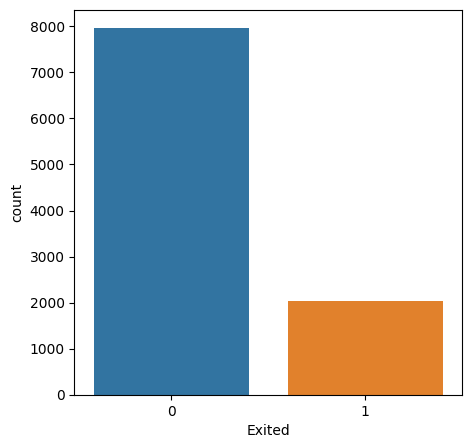

In [7]:
%matplotlib inline

plt.figure(figsize=(5,5))
sns.countplot(x='Exited', data=df)
plt.show()

Let's take a closer look at how churn rate can be further broken down.

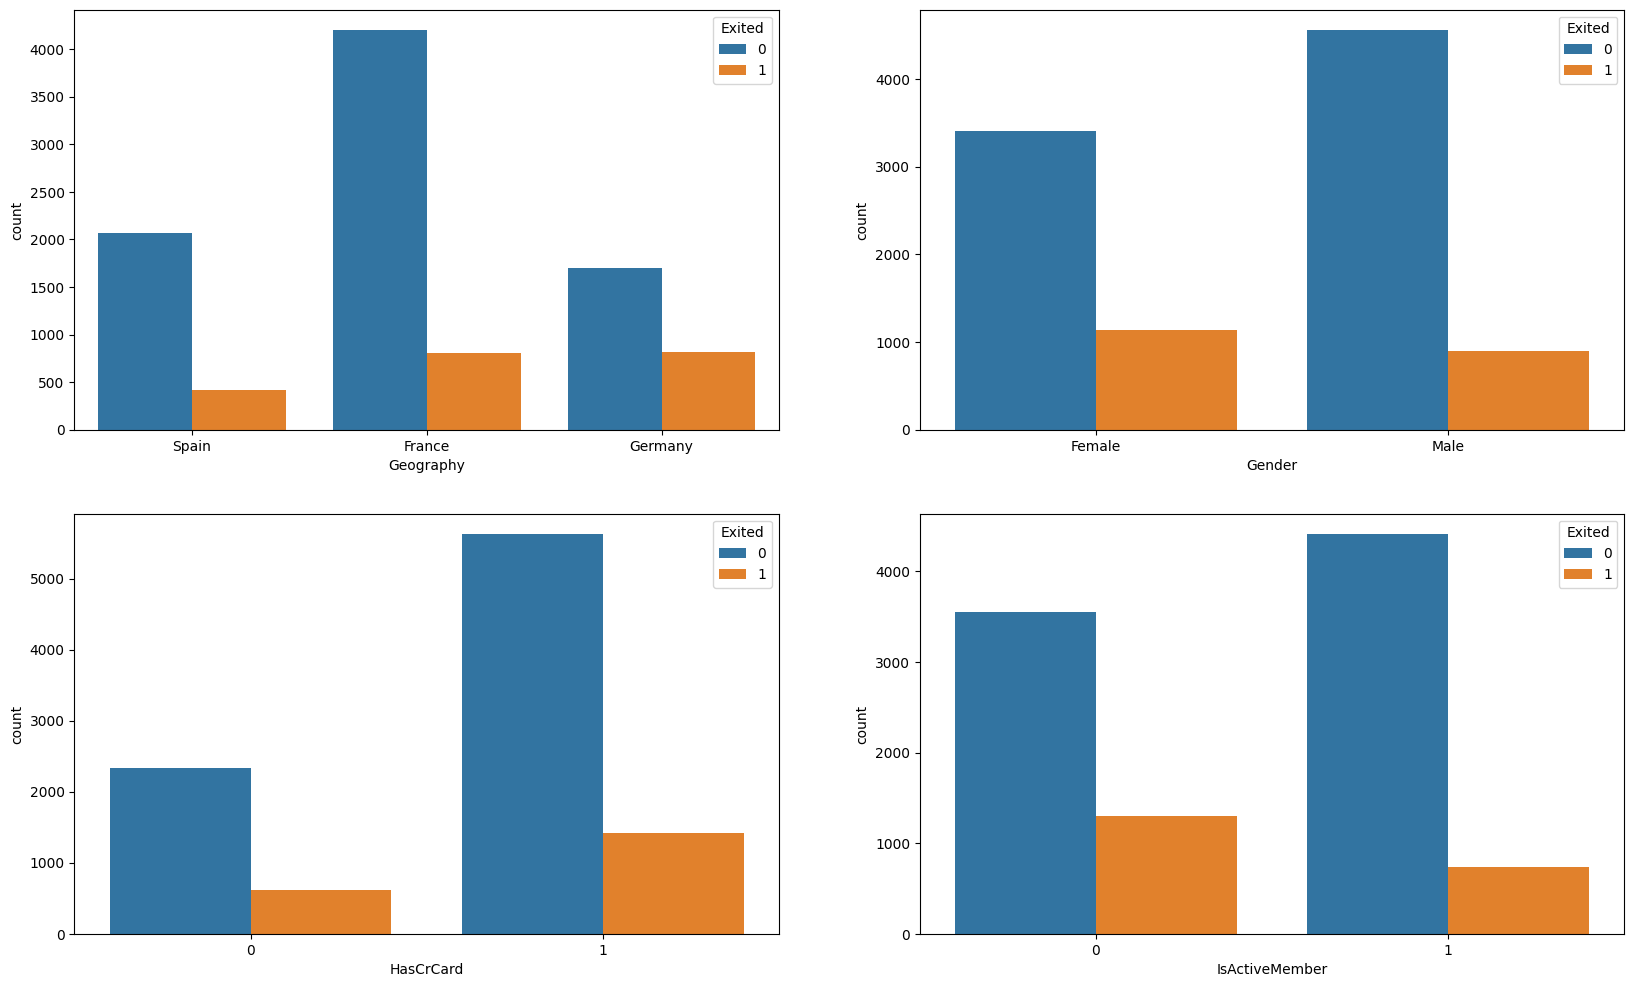

In [8]:
df_sorted = df.sort_values('Exited')

fig, axarr = plt.subplots(2, 2, figsize=(20, 12))

sns.countplot(x='Geography', hue='Exited', data=df_sorted, ax=axarr[0][0])
sns.countplot(x='Gender', hue='Exited', data=df_sorted, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue='Exited', data=df_sorted, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue='Exited', data=df_sorted, ax=axarr[1][1])

plt.show()

Let's develop a heatmap analysis, using only the numerical values of the dataset. 

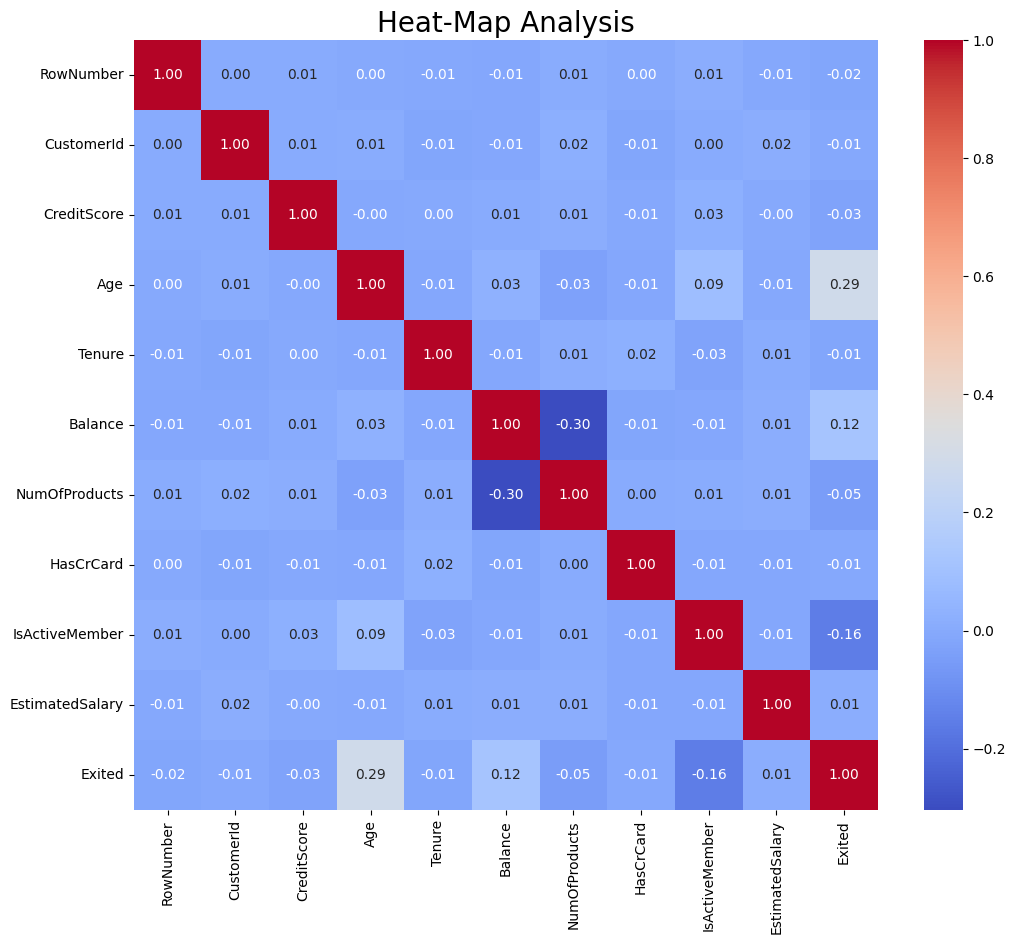

In [9]:
f, ax = plt.subplots(figsize= [12,10])
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", ax=ax, cmap = "coolwarm" )
ax.set_title("Heat-Map Analysis", fontsize=20)
plt.show()

Now we can begin to split the data into a training set and testing set to determine if our model can predict if a customer will exit or not.

In [10]:
# Dropping unnecessary columns
columns_to_drop = ['RowNumber', 'CustomerId', 'Surname']
for col in columns_to_drop:
    if col in df.columns:
        df = df.drop(columns=col)

# Assuming 'Exited' is the target variable
X = df.drop('Exited', axis=1)
y = df['Exited']

# Preprocessing: Defining column transformer for scaling & encoding
numeric_feat = X.select_dtypes(include=['int64', 'float64']).columns
categorical_feat = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_feat),
        ('cat', OneHotEncoder(), categorical_feat)
    ]
)

# Split the data into a training set and a testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create pipeline with preprocessing, feature selection, logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=10)),  # Utilizing top 10 features
    ('classifier', LogisticRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

Model accuracy: 0.8115


Our model has an accuracy of 81.15%, meaning it can predict if a customer will exit or not about 81% of the time using our modified dataset.

## Running Classification Models on Provided Dataset - Robby Dosanjh & Michael Berbach

In Part 3, we used predictive modeling aspect of our churn prediction project and to evaluate various machine learning models to determine which performs best at predicting customer churn based on the dataset provided.

The dataset we used was Churn_Modelling.csv

We used LabelEncoder to numerically transform the Geography and Gender columns, converting categorical information into a format understandable by our models. Columns like RowNumber, CustomerId, and Surname were removed since they contributed no predictive value to the churn outcome. To standardize the range of our continuous input features, we employed StandardScaler. This step is particularly beneficial for distance-based models and can significantly impact their performance.

Machine Learning Models:
Naïve Bayes (GaussianNB),
K-Nearest Neighbors (KNN),
Support Vector Machine (SVM),
Decision Tree, and 
Logistic Regression.
Each model was trained on the preprocessed training dataset and evaluated on a separate testing dataset to gauge its predictive accuracy.

When we created the model For KNN, the K value for K (neighbors) and that gave us the highest accuracy was 20.

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Encode categorical variables
label_encoder = LabelEncoder()
df['Geography'] = label_encoder.fit_transform(df['Geography'])
df['Gender'] = label_encoder.fit_transform(df['Gender'])

In [12]:
# Checking for dupes
print('Number of instances = %d' % (df.shape[0]))
dups = df.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))

Number of instances = 10000
Number of duplicate rows = 0


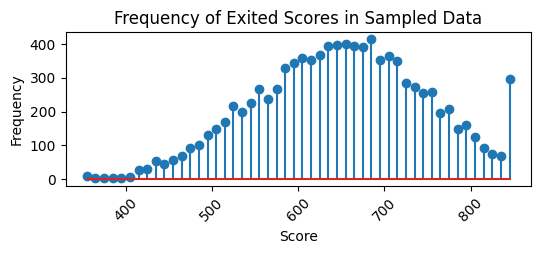

In [13]:
# Plotting the histogram
# Obtain the counts and the corresponding values
counts, bin_edges = np.histogram(df['CreditScore'], bins=50)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(6, 2))
plt.stem(bin_centers, counts)
plt.title('Frequency of Exited Scores in Sampled Data')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

## K-Nearest Neighbor (KNN)

In [14]:
# Splitting the dataset
X = df.drop('Exited', axis=1)
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

[0 0 0 ... 1 0 1]
[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]
[0 0 0 ... 1 0 0]


Text(0, 0.5, 'Accuracy')

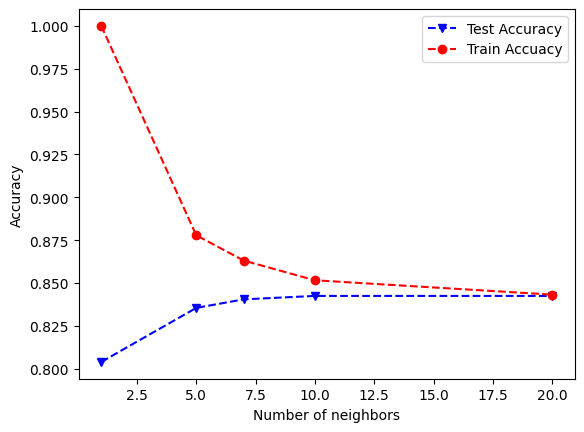

In [15]:
numNeighbors = [1, 5, 7, 10, 20]
testAcc = []
trainAcc = []

for k in numNeighbors:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    knn_pred = clf.predict(X_test)
    knn_pred_train = clf.predict(X_train)
    print(knn_pred)
    testAcc.append(accuracy_score(y_test, knn_pred))
    trainAcc.append(accuracy_score(y_train, knn_pred_train))

plt.plot(numNeighbors, testAcc,'bv--',numNeighbors, trainAcc, 'ro--')
plt.legend(['Test Accuracy','Train Accuacy'])
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

## Accuracy Analysis and Comparing Models - Robby Dosanjh & Michael Berbach

In [16]:
# Training and evaluating models
models = {
    'Naïve Bayes': GaussianNB(),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000)
}

accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracies[name] = accuracy_score(y_test, predictions)

# Displaying accuracies
for model, acc in accuracies.items():
    print(f"{model}: {acc * 100:.2f}%")

Naïve Bayes: 82.85%
KNN: 84.25%
SVM: 85.75%
Decision Tree: 78.95%
Logistic Regression: 81.50%


As we can see, the SVM model had the highest accuracy out of all the other models. SVMs are known for their high accuracy with two-group classification problems, such as when we are trying to predict whether a customer has exited or not.